In [13]:
import geopy.distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from scipy.signal import savgol_filter

In [14]:
#CONSTANTS

##Filtering
FIRST_LOWPASS_SENSORS = 1  #seconds
FIRST_LOWPASS_SENSORS_FREQ = str(FIRST_LOWPASS_SENSORS) + 's'  # for groupby freq
LONG_WINDOW = 60  #seconds
SHORT_WINDOW = 15  #seconds
SLIDING_WINDOW = max(LONG_WINDOW, SHORT_WINDOW)  #seconds

##Thresholds
STABLE_THRESHOLD = 0.05  # m/s
ASCENT_THRESHOLD = 0.8  # m/s (conversion factor 1m/s:3.6 km/h)
DESCENT_THRESHOLD = -1.0  # m/s (conversion factor 1m/s:3.6 km/h)

##Misc.
IDLE, SKIING, LIFT = range(3)  # states

In [15]:
#INPUT FILES
DIRECTORY = 'am1_verbier'  #directory containing the files for a specific activity

raw_barometer = pd.read_csv('input_data/' + DIRECTORY + '/Barometer.csv')
raw_GPS = pd.read_csv('input_data/' + DIRECTORY + '/Location.csv')

In [16]:
# PREPROCESSING
# convert to datetime (from unix timestamp in nanoseconds)
raw_barometer['time'] = pd.to_datetime(raw_barometer['time'])
raw_GPS['time'] = pd.to_datetime(raw_GPS['time'])

In [17]:
# preprocessing of raw sensor readings
## group by 1 second (LOW-PASS FILTER)
pre_barometer = raw_barometer.groupby(pd.Grouper(key='time', freq=FIRST_LOWPASS_SENSORS_FREQ)).mean()
pre_GPS = raw_GPS.groupby(pd.Grouper(key='time', freq=FIRST_LOWPASS_SENSORS_FREQ)).mean()

## interpolate missing data if missing to have continuous time series on column time
pre_barometer = pre_barometer.interpolate(method='time')
pre_GPS = pre_GPS.interpolate(method='time')

## add index
pre_barometer.reset_index(inplace=True)
pre_GPS.reset_index(inplace=True)

In [18]:
# merge barometer and GPS on index
preprocessed_data = pd.merge(pre_barometer, pre_GPS, left_index=True, right_index=True, how='inner')

In [19]:
# STATE MACHINE
# state machine driver
def update_state(prev, short, long):
    ## from state LIFT
    if prev == LIFT and -STABLE_THRESHOLD < long < STABLE_THRESHOLD and -STABLE_THRESHOLD < short < STABLE_THRESHOLD:
        return ['A',IDLE]

    elif prev == LIFT and short < DESCENT_THRESHOLD:
        return ['B',SKIING]

    elif prev == LIFT and short > ASCENT_THRESHOLD:
        return ['C',LIFT]

    ## from state SKIING
    elif prev == SKIING and -STABLE_THRESHOLD < long < STABLE_THRESHOLD and -STABLE_THRESHOLD < short < STABLE_THRESHOLD:
        return ['D',IDLE]

    elif prev == SKIING and short > ASCENT_THRESHOLD:
        return ['E',LIFT]

    elif prev == SKIING and short < DESCENT_THRESHOLD:
        return ['F',SKIING]

    ## from state IDLE
    elif prev == IDLE and -STABLE_THRESHOLD < long < STABLE_THRESHOLD and -STABLE_THRESHOLD < short < STABLE_THRESHOLD:
        return ['G',IDLE]

    elif prev == IDLE and short > ASCENT_THRESHOLD:
        return ['H',LIFT]

    elif prev == IDLE and short < DESCENT_THRESHOLD:
        return ['I',SKIING]

    ## no change
    else:
        return [None,prev]

In [20]:
# DATA STRUCTURE FOR INPUT DATA
# data structure to hold sensor data (as if it was fed from raw sensor after low-pass filtering)
data = preprocessed_data[
    ['relativeAltitude', 'speed', 'latitude', 'longitude']]

# data structure to hold working data
live_data = pd.DataFrame(columns=[
    'relativeAltitude', 'latitude', 'longitude', 'speed', 'smoothedAltitude',
    'run_start', 'run_time', 'activity_time',  # time
    'state', 'n_runs',  # state
    'top_speed_run', 'top_speed_total', 'avg_speed_run',  #speed
    'max_altitude_run', 'max_altitude_total',  # altitude
    'ascent_run', 'ascent_total',  # ascent
    'descent_run', 'descent_total',  # descent
    'distance_run', 'distance_total'])  #distance])

In [21]:
# DATA STRUCTURE FOR METRICS
stats_time = {
    # TIME
    'start_time_total': 0,
    'start_time_run': 0,
    'current_time': 0,
    'total_time': 0,
    'run_time': 0
}
stats_state = {
    # STATE
    'number_of_runs': 0,
    'current_state': IDLE
}
stats_speed = {
    # SPEED
    'top_speed_total': 0,
    'avg_speed_total': 0,
    'top_speed_run': 0,
    'avg_speed_run': 0,
    'current_speed': 0
}
stats_altitude = {
    # ALTITUDE
    'max_altitude_total': 0,
    'min_altitude_total': 0,
    'avg_altitude_total': 0,
    'max_altitude_run': 0,
    'min_altitude_run': 0,
    'avg_altitude_run': 0,
    'current_altitude': 0
}

stats_vertical = {
    # VERTICAL
    'ascent_total': 0,
    'descent_total': 0,
    'ascent_run': 0,
    'descent_run': 0
}
stats_distance = {
    # DISTANCE
    'distance_total': 0,
    'distance_run': 0,
}

In [22]:
# METRIC UPDATE FUNCTIONS

def update_time_run(curr_time):
    stats_time['current_time'] = curr_time - stats_time['start_time_run']
    return


def update_speed_run(curr_speed):
    n_samples = stats_time['current_time']
    stats_speed['current_speed'] = curr_speed
    stats_speed['top_speed_run'] = max(curr_speed, stats_speed['top_speed_run'])
    stats_speed['avg_speed_run'] = (stats_speed['avg_speed_run'] * n_samples) / (n_samples + 1) + curr_speed / (
            n_samples + 1)
    return


def update_altitude_run(curr_altitude):
    stats_altitude['max_altitude_run'] = max(curr_altitude, stats_altitude['max_altitude_run'])
    return


def update_vertical_run(curr_delta):
    if curr_delta > 0:
        stats_vertical['ascent_run'] += curr_delta
    else:
        stats_vertical['descent_run'] += curr_delta
    return


def update_distance_run(prev_lat, prev_lon, curr_lat, curr_lon):
    stats_distance['distance_run'] += geopy.distance.geodesic((prev_lat, prev_lon), (curr_lat, curr_lon)).m
    return


def update_df(index):
    # TIME
    live_data.at[index, 'activity_time'] = stats_time['total_time']
    live_data.at[index, 'run_time'] = stats_time['current_time']
    live_data.at[index, 'run_start'] = stats_time['start_time_run']
    # STATE
    live_data.at[index, 'n_runs'] = stats_state['number_of_runs']
    # SPEED
    live_data.at[index, 'top_speed_run'] = stats_speed['top_speed_run']
    live_data.at[index, 'avg_speed_run'] = stats_speed['avg_speed_run']
    live_data.at[index, 'top_speed_total'] = stats_speed['top_speed_total']
    # ALTITUDE
    live_data.at[index, 'max_altitude_run'] = stats_altitude['max_altitude_run']
    live_data.at[index, 'max_altitude_total'] = stats_altitude['max_altitude_total']
    # ASCENT
    live_data.at[index, 'ascent_run'] = stats_vertical['ascent_run']
    live_data.at[index, 'ascent_total'] = stats_vertical['ascent_total']
    # DESCENT
    live_data.at[index, 'descent_run'] = stats_vertical['descent_run']
    live_data.at[index, 'descent_total'] = stats_vertical['descent_total']
    # DISTANCE
    live_data.at[index, 'distance_run'] = stats_distance['distance_run']
    live_data.at[index, 'distance_total'] = stats_distance['distance_total']


def start_run_stats(curr_time):
    stats_time['start_time_run'] = curr_time
    return


# ran at the end of the run
def consume_run_stats():
    # TIME
    stats_time['total_time'] += stats_time['current_time']
    n_samples = stats_time['total_time']
    stats_time['start_time_run'] = 0
    stats_time['current_time'] = 0
    # STATE
    stats_state['number_of_runs'] += 1
    # SPEED
    stats_speed['top_speed_total'] = max(stats_speed['top_speed_run'], stats_speed['top_speed_total'])
    stats_speed['top_speed_run'] = 0
    stats_speed['avg_speed_run'] = 0
    # ALTITUDE
    stats_altitude['max_altitude_total'] = max(stats_altitude['max_altitude_run'], stats_altitude['max_altitude_total'])
    stats_altitude['max_altitude_run'] = 0
    # VERTICAL
    stats_vertical['ascent_total'] += stats_vertical['ascent_run']
    stats_vertical['ascent_run'] = 0
    stats_vertical['descent_total'] += stats_vertical['descent_run']
    stats_vertical['descent_run'] = 0
    # DISTANCE
    stats_distance['distance_total'] += stats_distance['distance_run']
    stats_distance['distance_run'] = 0
    return

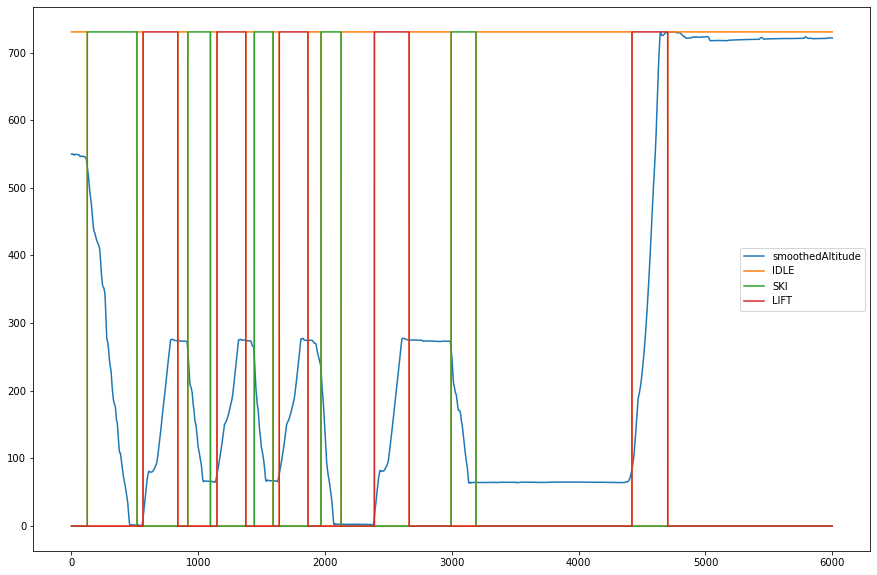

In [23]:
df_out = pd.DataFrame(live_data)  # for output visualisation

original_length = len(data)

# while there are rows in data, consume the oldest data point
while data.shape[0] > 0:
    n = original_length - data.shape[0]
    # load last reading
    current_row = data.iloc[0].copy()  # consume oldest available data
    data = data.iloc[1:]  # remove consumed data
    current_row['state'] = 0  # default state, to be modified by state machine

    #append new data in live_data
    live_data = pd.concat([live_data, current_row.to_frame().T], axis=0, ignore_index=True)

    #if the sliding window is filled with data, consume the oldest data
    len_live_data = live_data.shape[0] - 1
    if len_live_data >= SLIDING_WINDOW:

        # filtering
        live_data['smoothedAltitude'] = savgol_filter(live_data['relativeAltitude'], 15, 2)

        # features
        first_derivative_short = np.mean(np.diff(live_data['smoothedAltitude'])[-SHORT_WINDOW:])
        first_derivative_long = np.mean(np.diff(live_data['smoothedAltitude'])[-LONG_WINDOW:])

        previous_state = live_data['state'].iloc[
            -2]  # since we started appending a new row, -1 is current row, -2 is actual previous

        next_state = update_state(previous_state, first_derivative_short, first_derivative_long)
        live_data.at[len_live_data, 'state'] = next_state[1]

        # if in state SKIING, update stats for run
        if previous_state == SKIING:
            update_time_run(n)
            update_speed_run(live_data['speed'].iloc[-1])
            update_altitude_run(live_data['relativeAltitude'].iloc[-2])
            update_vertical_run(live_data['relativeAltitude'].iloc[-2] - live_data['relativeAltitude'].iloc[-3])
            update_distance_run(live_data['latitude'].iloc[-2], live_data['longitude'].iloc[-2],
                                live_data['latitude'].iloc[-3], live_data['longitude'].iloc[-3])

        # if enter LIFT state from SKIING or IDLE
        if next_state[0] == 'E' or next_state[0] == 'H':
            consume_run_stats()

        # if enter SKIING state from LIFT or IDLE
        if next_state[0] == 'B' or next_state[0] == 'I':
            start_run_stats(n)

        # update the datastructure
        update_df(len_live_data)

    # for visualisation, stop every 10 minutes
    if (n % 600) == 0:

        clear_output(wait=True)
        min1 = min(live_data['smoothedAltitude'])
        max1 = max(live_data['smoothedAltitude'])
        plt.plot(live_data['smoothedAltitude'].map(lambda x: x - min1))

        #create three lists for each state
        list_IDLE = []
        list_SKI = []
        list_LIFT = []
        #for each row of live data, set list_IDLE to 1 if state = 0, 0 otherwise
        scale = max1 - min1
        for i in range(len(live_data)):
            if live_data['state'].iloc[i] == 0:
                list_IDLE.append(scale)
            else:
                list_IDLE.append(0)
            if live_data['state'].iloc[i] == 1:
                list_SKI.append(scale)
            else:
                list_SKI.append(0)
            if live_data['state'].iloc[i] == 2:
                list_LIFT.append(scale)
            else:
                list_LIFT.append(0)
        plt.plot(list_IDLE)
        plt.plot(list_SKI)
        plt.plot(list_LIFT)

        plt.legend(['smoothedAltitude', 'IDLE', 'SKI', 'LIFT'])
        #enlarge figure
        plt.gcf().set_size_inches(15, 10)
        plt.show()

In [28]:
## OUTPUT DATA TO DASHBOARD
# get first hour of live_data
output = live_data.iloc[0:3600]
output.to_csv('output_data/output.csv')